### Import Dependencies

In [38]:
from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery, Document


from langsmith import traceable, get_current_run_tree

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.types import Send, Command

from langchain_core.messages import AIMessage, ToolMessage

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional, Sequence
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import inspect
import instructor
import json

from utils.utils import get_tool_descriptions, format_ai_message

In [39]:
qdrant_client = QdrantClient(url="http://localhost:6333")

In [40]:
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding

In [41]:
def retrieve_data(query, qdrant_client, k=5):

    query_embedding = get_embedding(query)

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=query,
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )

    retrieved_context_ids = []
    retrieved_context = []
    retrieved_context_ratings = []
    similarity_scores = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])
        similarity_scores.append(result.score)

    return {
        "retrieved_context_ids": retrieved_context_ids,
        "retrieved_context": retrieved_context,
        "retrieved_context_ratings": retrieved_context_ratings,
        "similarity_scores": similarity_scores,
    }

In [42]:
query = "Can I get some tablet?"

In [43]:
answer = retrieve_data(query, qdrant_client, k=10)

In [44]:
answer

{'retrieved_context_ids': ['B09P29VXG1',
  'B09F8TLBZL',
  'B0C78B1BTB',
  'B09VP8SZSR',
  'B0B44TGKRX',
  'B09TFS9298',
  'B0C35RS6MS',
  'B0BTCSVPQH',
  'B0C8PF45CL',
  'B0C9QCRNBK'],
 'retrieved_context': ['SAMSUNG Galaxy Tab A8 10.5” 64GB Android Tablet, LCD Screen, Kids Content, Smart Switch, Long Lasting Battery, US Version, 2022, Silver, Amazon ExclusiveA SCREEN EVERYONE WILL LOVE: Whether your family is streaming or video chatting with friends, the Galaxy Tab A8 tablet brings out the best in every moment on a 10.5" LCD screen POWER AND STORAGE FOR ALL: Get the power, storage and speed your family needs with an upgraded chipset and plenty of room to keep files — up to 128GB of storage; a long-lasting battery lets you go unplugged for hours to keep the family fun going CHARGE FAST, POWER FOR HOURS: Go for hours on a single charge and back to 100% with the fast charging USB C port; Battery life may vary depending on network environment, usage patterns and other factors GALAXY ECOS

### Multi-Intention Question

In [45]:
query = "Can I get a tablet for my kid, a watch for me and a laptop for my wife?"

In [46]:
answer = retrieve_data(query, qdrant_client, k=10)

In [47]:
answer

{'retrieved_context_ids': ['B09P29VXG1',
  'B0BVLDTNCB',
  'B0BWRPM57L',
  'B0BXDLW66J',
  'B0B44TGKRX',
  'B0B6CBS5CJ',
  'B08BYFJTD5',
  'B0C9QCRNBK',
  'B09VP8SZSR',
  'B0C78B1BTB'],
 'retrieved_context': ['SAMSUNG Galaxy Tab A8 10.5” 64GB Android Tablet, LCD Screen, Kids Content, Smart Switch, Long Lasting Battery, US Version, 2022, Silver, Amazon ExclusiveA SCREEN EVERYONE WILL LOVE: Whether your family is streaming or video chatting with friends, the Galaxy Tab A8 tablet brings out the best in every moment on a 10.5" LCD screen POWER AND STORAGE FOR ALL: Get the power, storage and speed your family needs with an upgraded chipset and plenty of room to keep files — up to 128GB of storage; a long-lasting battery lets you go unplugged for hours to keep the family fun going CHARGE FAST, POWER FOR HOURS: Go for hours on a single charge and back to 100% with the fast charging USB C port; Battery life may vary depending on network environment, usage patterns and other factors GALAXY ECOS

In [48]:
class QueryExpandResponse(BaseModel):
   statements: List[str]

In [49]:
def query_expand_node(query) -> dict:

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context.

<Question>
{{ query }}
</Question>
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      query=query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "queries": response.statements
   }

In [50]:
answer = query_expand_node(query)

In [51]:
answer

{'queries': ['tablet suitable for kids',
  'smartwatch for adults',
  'laptop for women']}

# LangGraph

## Query Expansion (Sequential Execution)

In [52]:
class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    initial_query: str = ""
    answer: str = ""

### Query Expansion / Rewriting Node

In [53]:
class QueryExpandResponse(BaseModel):
    expanded_query: List[str]

In [54]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def query_expand_node(state: State):

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context. Single item should not be expanded into multiple statements unless it is specifically mentioned in several contexts.

<Question>
{{ query }}
</Question>
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      query=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "expanded_query": response.expanded_query
      }

### Retriever Node

In [55]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )

    return response.data[0].embedding

@traceable(
    name="retrieve_top_n",
    run_type="retriever"
)
def retrieve(query, k=10) -> dict:

    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(query)

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=query,
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )

    retrieved_context = []
    retrieved_context_ids = [] 
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])

    formatted_context = ""

    for id, chunk, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"

    return formatted_context


@traceable(
    name="retriever_node",
    run_type="retriever"
)
def retrieve_node(state: State) -> dict:

    retrieved_context = []

    for query in state.expanded_query:
        retrieved_context.append(retrieve(query))

    return {
        "retrieved_context": retrieved_context
    }

### Aggregator Node

In [56]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question.")

In [57]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def aggregator_node(state: State) -> dict:

   preprocessed_context = "\n".join(state.retrieved_context)

   prompt_template =  """You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of context.

Instructions:
- You need to answer the question based on the provided context only.
- Never use word context and refer to it as the available products.
- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

Context:
{{ preprocessed_context }}

Question:
{{ question }}
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      preprocessed_context=preprocessed_context,
      question=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AggregatorResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "answer": response.answer
   }

In [58]:
workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retriever_node", retrieve_node)
workflow.add_node("aggregator_node", aggregator_node)

workflow.add_edge(START, "query_expand_node")
workflow.add_edge("query_expand_node", "retriever_node")
workflow.add_edge("retriever_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()

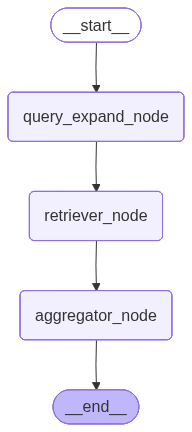

In [59]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [60]:
initial_state = {
    "initial_query": "Can I get a tablet for my kid, a watch for me and a laptop for my wife?"
}
result = graph.invoke(initial_state)

In [61]:
result

{'expanded_query': ['tablet for kids', 'watch for adults', 'laptop for wife'],
 'retrieved_context': ['- ID: B09P29VXG1, rating: 4.5, description: SAMSUNG Galaxy Tab A8 10.5” 64GB Android Tablet, LCD Screen, Kids Content, Smart Switch, Long Lasting Battery, US Version, 2022, Silver, Amazon ExclusiveA SCREEN EVERYONE WILL LOVE: Whether your family is streaming or video chatting with friends, the Galaxy Tab A8 tablet brings out the best in every moment on a 10.5" LCD screen POWER AND STORAGE FOR ALL: Get the power, storage and speed your family needs with an upgraded chipset and plenty of room to keep files — up to 128GB of storage; a long-lasting battery lets you go unplugged for hours to keep the family fun going CHARGE FAST, POWER FOR HOURS: Go for hours on a single charge and back to 100% with the fast charging USB C port; Battery life may vary depending on network environment, usage patterns and other factors GALAXY ECOSYSTEM: Open up a new world of convenient possibilities with the

In [62]:
print(result["answer"])

Yes, you can get a tablet for your kid, a watch for yourself, and a laptop for your wife from the available products. Here are some options:

Tablet for Kid:
- SAMSUNG Galaxy Tab A8 10.5” 64GB Android Tablet
  - 10.5" LCD screen
  - Upgraded chipset with up to 128GB storage
  - Long-lasting battery with fast charging USB-C port
  - Kids content and Samsung Kids app for safe learning
  - Galaxy ecosystem compatibility

Watch for You:
- OTOSAGOW Smart Watch for Men Women
  - 1.45" HD touch screen
  - 111 sports modes and IP68 waterproof
  - Heart rate, blood oxygen, blood pressure, and sleep monitoring
  - Bluetooth call and message reminder
  - Long battery life with magnetic charging

- MgaoLo Kids Smart Watch (also suitable for teens and adults)
  - 1.4-inch colorful touch screen
  - Heart rate and sleep monitor
  - DIY watch face
  - 5-7 days battery life

Laptop for Your Wife:
- LOVEVOOK Laptop Bag for Women 15.6 Inch (if you want a bag)
- Fusion5 14.1" T90 N4 Intel Quad Core Window

## Query Expansion (Parallel Execution)

In [63]:
class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    initial_query: str = ""
    answer: str = ""
    query: str = ""
    k: int = 10

### Query Expansion / Rewriting Node

In [64]:
class QueryExpandResponse(BaseModel):
    expanded_query: List[str]

In [65]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def query_expand_node(state: State):

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context. Single item should not be expanded into multiple statements unless it is specifically mentioned in several contexts.

<Question>
{{ query }}
</Question>
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      query=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "expanded_query": response.expanded_query
      }

In [66]:
def query_expand_conditional_edges(state: State):

    send_messages = []

    for query in state.expanded_query:
        send_messages.append(
            Send(
                "retrieve_node",
                {
                    "query": query,
                    "k": 10
                }
            )
        )

    return send_messages

### Retriever Node

In [67]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )

    return response.data[0].embedding

@traceable(
    name="retrieve_top_n",
    run_type="retriever"
)
def retrieve_node(state: State) -> dict:

    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(state["query"])

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=state["query"],
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=state["k"],
    )

    retrieved_context = []
    retrieved_context_ids = [] 
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])

    formatted_context = ""

    for id, chunk, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"

    return {
        "retrieved_context": [formatted_context],
    }

### Aggregator Node

In [68]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question.")

In [69]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def aggregator_node(state: State) -> dict:

   preprocessed_context = "\n".join(state.retrieved_context)

   prompt_template =  """You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of context.

Instructions:
- You need to answer the question based on the provided context only.
- Never use word context and refer to it as the available products.
- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

Context:
{{ preprocessed_context }}

Question:
{{ question }}
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      preprocessed_context=preprocessed_context,
      question=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AggregatorResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "answer": response.answer
   }

### Graph

In [70]:
workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retrieve_node", retrieve_node)
workflow.add_node("aggregator_node", aggregator_node)

workflow.add_edge(START, "query_expand_node")
workflow.add_conditional_edges("query_expand_node", query_expand_conditional_edges)

workflow.add_edge("retrieve_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()

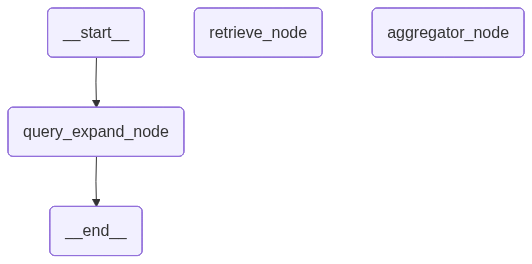

In [71]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [72]:
initial_state = {
    "initial_query": "Can I get a tablet for my kid, a watch for me and a laptop for my wife?"
}
result = graph.invoke(initial_state)

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

In [73]:
result

{'expanded_query': ['tablet for kids', 'watch for adults', 'laptop for women'],
 'retrieved_context': ['- ID: B09P29VXG1, rating: 4.5, description: SAMSUNG Galaxy Tab A8 10.5” 64GB Android Tablet, LCD Screen, Kids Content, Smart Switch, Long Lasting Battery, US Version, 2022, Silver, Amazon ExclusiveA SCREEN EVERYONE WILL LOVE: Whether your family is streaming or video chatting with friends, the Galaxy Tab A8 tablet brings out the best in every moment on a 10.5" LCD screen POWER AND STORAGE FOR ALL: Get the power, storage and speed your family needs with an upgraded chipset and plenty of room to keep files — up to 128GB of storage; a long-lasting battery lets you go unplugged for hours to keep the family fun going CHARGE FAST, POWER FOR HOURS: Go for hours on a single charge and back to 100% with the fast charging USB C port; Battery life may vary depending on network environment, usage patterns and other factors GALAXY ECOSYSTEM: Open up a new world of convenient possibilities with th

In [74]:
print(result["answer"])

Yes, you can get a tablet for your kid, a watch for yourself, and a laptop for your wife from the available products. Here are some options with detailed specifications:

Tablet for Kid:
- SAMSUNG Galaxy Tab A8 10.5” 64GB Android Tablet
  - 10.5" LCD screen
  - 64GB storage, expandable up to 128GB
  - Long lasting battery with fast charging USB C port
  - Kids content and Samsung Kids mode for safe learning
  - Galaxy ecosystem compatibility
  - Smart Switch for easy data transfer
  - Color: Silver
  - US Version, 2022
  - Amazon Exclusive

Smart Watch for You:
- OTOSAGOW Smart Watch for Men Women
  - 1.45'' HD full touch color screen
  - 111 sports modes including running, cycling, swimming, climbing, yoga
  - Heart rate, blood oxygen, blood pressure, sleep monitoring
  - IP68 waterproof
  - Bluetooth call and message reminder
  - Customizable watch faces
  - Long battery life: 25 days standby, 7 days daily use
  - Compatible with Android and iOS

Laptop for Your Wife:
- LOVEVOOK Lapt